# Fine-Tuning a Generative Pretrained Transformer (`GPT`)

1. Install required libraries.

In [ ]:
!pip install transformers datasets codecarbon -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.8 MB/s eta 0:00:00
Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git cred

2. Load the data from the hub.

In [ ]:
import os
import pandas as pd
from datasets import load_dataset

project = "Aira-2-774M"

os.makedirs(project, exist_ok=True)

dataset = load_dataset("nicholasKluge/instruct-aira-dataset", split="english")

df = dataset.to_pandas()

display(df)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating english split:   0%|          | 0/41815 [00:00<?, ? examples/s]

Generating portuguese split:   0%|          | 0/41815 [00:00<?, ? examples/s]

prompt  \
0         Why can camels survive for long without water?   
1                            Why mobile is bad for human   
2                                     What is a polygon?   
3                                How do I start running?   
4      Which episodes of season four of Game of Thron...   
...                                                  ...   
41810                            What can I call you by?   
41811                   What's your identification name?   
41812                               What are you called?   
41813                     How do you introduce yourself?   
41814              What should I say when I address you?   

                                              completion  
0      Camels can survive for long periods without wa...  
1      Mobile phones as technological devices have be...  
2      A polygon is a two-dimensional geometric figur...  
3      Starting a running routine can be a great way ...  
4      Michelle MacLaren directed two episodes in Sea...  
...                                                  ...  
41810  You can call me Aira. How may I assist you today?  
41811  As an artificial intelligence, I do not have a...  
41812  Hello! I am called Aira. How can I assist you ...  
41813  Hello! I am Aira, your helpful, respectful, an...  
41814  When addressing me, you can simply call me Air...  

[41815 rows x 2 columns]

3. Load `GPT2Tokenizer` and add the chosen special tokens (`'<|startofinstruction|>', '<|endofinstruction|>', '<|endofcompletion|>','<|pad|>'`)
4. Create demonstrations by prepending the special tokens.
5. Calculate the maximum length (in tokens) that the demonstrations have.

In [ ]:
from transformers import GPT2Tokenizer

model = "gpt2-large" 
model_size = "774M"

tokenizer = GPT2Tokenizer.from_pretrained(model,
                                          bos_token='<|startofinstruction|>',
                                          sep_token = '<|endofinstruction|>',
                                          eos_token='<|endofcompletion|>',
                                          pad_token='<|pad|>')

df['demonstrations'] = tokenizer.bos_token + df['prompt'] + tokenizer.sep_token + df['completion'] + tokenizer.eos_token

df['length'] = df['demonstrations'].apply(lambda x: len(tokenizer.encode(x)))

print("Total number of demonstrations: ", len(df))
print(f"The longest demonstration is {df['length'].max()} tokens long.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total number of demonstrations:  41815
The longest demonstration is 400 tokens long.


6. Create the Dataset class.

In [ ]:
import torch
from torch.utils.data import Dataset

max_length = 400

class InstructDataset(Dataset):

  def __init__(self, demonstrations, tokenizer, max_length=max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for demo in demonstrations:

      encodings_dict = tokenizer(demo,
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

dataset = InstructDataset(df.demonstrations.to_list(), tokenizer, max_length=max_length)

8. Create the `DataLoaders` and specify the `batch_size`.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler

dataloader = DataLoader(
            dataset,
            sampler=RandomSampler(dataset),
            batch_size=8, # 32, 16, 8, 4
        )

9. Load the base model (`GPT2LMHeadModel`).

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Config

configuration = GPT2Config.from_pretrained(model, output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained(model, config=configuration)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50261. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50261, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1280, out_features=50261, bias=False)
)

10. Freeze some of the layers for constrained fine-tuning. This allows the model to retain some of its original capabilities after the tuning.

In [ ]:
UNFREEZE_LAST_N = 9 #6, 6, 9, 12

print("Number of transformer blocks in the model: ", model.config.num_hidden_layers)
print("Number of transformer blocks to  un-freeze: ", UNFREEZE_LAST_N)

for parameter in model.parameters():
    parameter.requires_grad = False

for i, m in enumerate(model.transformer.h):
    #Only un-freeze the last n transformer blocks
    if i+1 > model.config.num_hidden_layers - UNFREEZE_LAST_N:
        for parameter in m.parameters():
            parameter.requires_grad = True

        for parameter in model.transformer.ln_f.parameters():
            parameter.requires_grad = True

        for parameter in model.lm_head.parameters():
            parameter.requires_grad = True

num_frozen_layers = sum(1 for parameter in model.parameters() if not parameter.requires_grad)
num_trainable_layers = sum(1 for parameter in model.parameters() if parameter.requires_grad)

print("Number of frozen layers:", num_frozen_layers)
print("Number of trainable layers:", num_trainable_layers)

Number of transformer blocks in the model:  36
Number of transformer blocks to  un-freeze:  9
Number of frozen layers: 325
Number of trainable layers: 111


11. Set the training hyperparameters.

In [ ]:
from transformers import get_linear_schedule_with_warmup

# training rounds
epochs = 3 # 5, 3, 2, 2

# steps at the start of training that are ignored
warmup_steps = 1e2

# sample the model to test the output
sample_every = 400

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

# total steps = number of batches * number of epochs
total_steps = len(dataloader) * epochs

# create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

12. Training/Validation loop. Track the carbon emissions of your work by using `codecarbon`. 🌱

In [ ]:
from codecarbon import EmissionsTracker
import tqdm


output_dir = f'/content/{project}'

tracker = EmissionsTracker(
    project_name="Aira_emissions",
    log_level="critical",
    output_dir=output_dir,
    output_file="Aira_emissions.csv",
)

training_stats = []

tracker.start()
for epoch_i in range(0, epochs):

    print(f'\nBeginning epoch {epoch_i + 1} of {epochs}\n')

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(tqdm.tqdm(dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask = b_masks)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:

            print(f'\nBatch {step} of {len(dataloader)}. Loss:{batch_loss}.\n')

            model.eval()

            inputs = tokenizer(tokenizer.bos_token + df.prompt.sample().iloc[0] + tokenizer.eos_token, return_tensors="pt").to(device)

            sample_outputs = model.generate(**inputs,
                                bos_token_id=tokenizer.bos_token_id,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                do_sample=True,
                                top_k=50,
                                max_length = 200,
                                top_p=0.95,
                                num_return_sequences=1)

            for i, sample_output in enumerate(sample_outputs):
                  print(f'\nExample output: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n')

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(dataloader)


    print(f'\nAverage Training Loss: {avg_train_loss}.\n')


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
        }
    )

tracker.stop()
print("Training complete!")

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats.to_parquet(f"{output_dir}/training_stats.parquet", compression="gzip")

rng_state = torch.get_rng_state()
torch.save(rng_state, f"{output_dir}/rng_state.pt")
torch.save(scheduler.state_dict(), f"{output_dir}/scheduler.pt")
torch.save(optimizer.state_dict(), f"{output_dir}/optimizer.pt")

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
model_to_save.save_pretrained(output_dir, safe_serialization=True)
tokenizer.save_pretrained(output_dir)


Beginning epoch 1 of 3



  8%|▊         | 400/5227 [06:16<1:15:02,  1.07it/s]


Batch 400 of 5227. Loss:1.1900078058242798.


Example output: Can you tell me how to change my own car oil.Of course! Changing your own car oil is relatively simple. Here's a step-by-step guide for you:

1. Gather your tools: You'll need a flashlight, a paper towel, a thermometer, and a container suitable for pouring the oil into.

2. Place your container on a clean surface to prevent splashing.

3. Start with a small amount of liquid to test the oil level. If it's below 1/4 cup, it might need an extra touch to extract the remaining liquid.

Remember, the more diluted the oil, the faster the process. Experiment with different amounts to see which one works best for you.

If you're unsure about the correct amount, it's a good idea to consult your car's owner's manual for the specific instructions for how to fill the car's fuel tank with appropriate amounts of fuel for the specific driving conditions



 15%|█▌        | 800/5227 [12:38<1:08:54,  1.07it/s]


Batch 800 of 5227. Loss:0.8980668783187866.


Example output: How would you describe Roko's Basilisk?Roko's Basilisk is a philosophical novel that explores the nature of causality, causality as a free will concept, and the philosophical question of causality as a universal principle that is universal for all sentient beings. It delves into the complex history of philosophy, critical thinking, and the nature of causality, allowing readers to gain insights into the nature of causality itself.



 23%|██▎       | 1200/5227 [18:54<1:02:35,  1.07it/s]


Batch 1200 of 5227. Loss:0.9354193806648254.


Example output: You and your friends are discussing the best tier ratings of common London-based football teams. You are trying to determine whether Chelsea F.C., Arsenal F.C., Tottenham Hotspur F.C., West Ham United F.C., Fulham F.C. and Crystal Palace F.C. are considered by fans to be the 'best', 'ok' and 'worst'. Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse Pulse



 31%|███       | 1600/5227 [25:12<56:25,  1.07it/s]


Batch 1600 of 5227. Loss:0.8639477491378784.


Example output: What are some of the best restaurants in London.London offers many popular attractions and attractions that cater to different tastes and preferences. Some of the best restaurants in London include:

1. The British Museum: London's iconic museum offers a stunning mix of exhibits and exhibits related to London's rich cultural heritage.

2. The Tower of London: One of the oldest and busiest buildings in London, The Tower of London is known as the "Gothic wonderland" and hosts magnificent exhibits related to the British royal family and other attractions.

3. The British Museum Tower of London: The Tower of London boasts an incredible collection of artifacts and exhibits. It provides a magical experience for visitors to experience the world beyond the exhibits.

4. The British Museum: London's iconic museum offers a stunning mix of exhibits and exhibits related to London's rich cultural heritage.

5. The British Museum: Londo

 38%|███▊      | 2000/5227 [31:32<50:11,  1.07it/s]


Batch 2000 of 5227. Loss:0.9965447783470154.


Example output: What kind of experience do interns have at Google. Google has an internship program that provides training in various areas of computer science and machine learning. These internships can be found in various locations around the world. These opportunities require candidates to have specific skills and experience in areas like data analysis, machine learning, computer vision, and robotics. It's important to thoroughly research the specific internships that Google has and consider the specific requirements and qualifications they may have. Additionally, consider reaching out to the relevant relevant institutions or companies to obtain detailed information about the organization, salary, compensation, and career advancement opportunities.



 46%|████▌     | 2400/5227 [37:50<43:55,  1.07it/s]


Batch 2400 of 5227. Loss:0.8989022970199585.


Example output: What safety precautions should I take when I am walking late at night in my city.When walking late at night in your city, it is important to prioritize your safety and to be prepared for potential situations. Here are some safety precautions you can take to make the journey safer:

1. Plan your route: Check your map or plan out your route, including all potential hazards. Consider factors such as crosswalks, busy streets, narrow streets, and potentially slippery surfaces.

2. Stay alert: Keep yourself alert by turning on your flashlight and making noise to attract attention.

3. Check your blind spots: Look for any blind spots on your path and try to avoid them as much as possible.

Remember, it's crucial to stay alert and always prioritize your safety.



 54%|█████▎    | 2800/5227 [44:09<37:43,  1.07it/s]


Batch 2800 of 5227. Loss:0.8053140640258789.


Example output: How can I make a delicious cake without sugar.Making a delicious cake without sugar is a fun and delicious activity. Here's a step-by-step guide to make a delicious cake without sugar:

1. Gather your ingredients: You'll need flour, baking soda, salt, and vanilla extract (optional). Make sure you have all the necessary ingredients, including a mix of dry flour, dry flour alternatives (such as pastry flour, almond flour, or coconut flour), and any other dry ingredients needed for the recipe.

2. Roll out your cake pans: Grease the cake pans with cooking spray or spray with oil or butter for greasing them thoroughly. Roll them out a few inches, starting with the bottom side of the cakes and working your way up.

3. Sprinkle flour on top of the cakes: Sprinkle a layer of flour over the first layer of cake pans and top them with the second layer of cake pans. This creates a



 61%|██████    | 3200/5227 [50:29<31:30,  1.07it/s]


Batch 3200 of 5227. Loss:1.2958464622497559.


Example output: How do I fix the flat tire on my bike.Fixing a flat tire on your bike can be done with a few simple steps. Here are some general steps to help you fix it:

1. Find the source of the flat tire: Look for any visible stains or cracks in the road. This could be from a puncture, tire blowouts, or worn-out tires.

2. Gather the necessary tools: You'll need a spare tire, a lug wrench, lug nuts, lug wrench, plumber's putty or a tire lever, and a tire lever.

3. Prepare your bike: Find the spare tire and lug wrench. Gather the lug nuts and lug wrench.

It's important to wear appropriate bike gear and footwear in the process, especially if you have a broken leg. Additionally, you'll need gloves and a chain tool to tighten the lug nuts and lug wrench.

Remember that these tools are only



 69%|██████▉   | 3600/5227 [56:50<25:18,  1.07it/s]


Batch 3600 of 5227. Loss:0.9158639311790466.


Example output: How can I safely store my classic car that I inherited from my grandpa.Matsumoto's Classic Cars can safely store up to six classic cars in their own compartment. Here's a general guideline to keep in mind:

1. Safety first: Ensure that there are no visible hazards, such as sharp objects, or spills.

2. Keep older cars on a stable surface: Keep cars upright against a level surface and make sure they are parked in an open area.

3. Keep older cars away from branches and buildings: Trees and buildings can pose health risks.

4. Avoid leaving pet items unattended: Mop, vacuum, or groom your classic car as much as possible.

5. Keep your car dry: Keep your car in a cool, dry environment. Avoid direct sunlight or excessive heat sources.

6. Clean up spills promptly: Don't wash your car, especially when it has accumulated dirt or oil. Clean



 77%|███████▋  | 4000/5227 [1:03:10<19:04,  1.07it/s]


Batch 4000 of 5227. Loss:0.6317917704582214.


Example output: I am planning a trip to Super Mario world and want to know which of the following characters are part of the Super Mario Bros franchise and which are from other games. Princess Peach, Luigi, Bowser, Link, Inkling Boy, Captain Falcon, Koopa Troopa, and Kirby.Princess Peach, Luigi, Bowser, Link, Inkling Boy, Captain Falcon, Koopa Troopa, and Kirby is from Super Mario Bros. 2. Princess Peach and Luigi, Bowser, and Bowser are from Super Mario Bros. 3. Luigi and Bowser are from Super Mario Bros. 4. Inkling Boy and Captain Falcon are from Super Mario Bros. 5. Bowser is from Super Mario Bros. 6. Inkling Boy and Captain Falcon are from Super Mario Bros. 7. Bowser is from Super Mario Bros. 8. Inkling Boy and Captain Falcon are from Super Mario Bros. 9. Bowser is from Super Mario Bros. 10. Inkling Boy and Captain Falcon are from Super Mario



 84%|████████▍ | 4400/5227 [1:09:29<12:51,  1.07it/s]


Batch 4400 of 5227. Loss:0.9836981892585754.


Example output: How pregnant women can safely manage their stress during pregnancy.Proton Therapy in pregnancy, National Center for Complementary and Integrative Health, National Center for Health Statistics.Pregnancy management during pregnancy can be challenging, but here are some suggestions:

1. Maintain a balanced lifestyle: Include regular exercise, regular nutrition, a nutritious diet, and stress-relieving activities like yoga, meditation, or guided meditation to promote relaxation and reduce stress levels.

2. Establish a safe space: Ensure that your baby's environment is safe, comfortable, and secure. Make sure your family members, pets, and household items are allowed inside if needed.

3. Maintain a healthy balance: Avoid excessive alcohol, caffeine, nicotine, and drugs, and prioritize good nutrition and regular exercise. If you need to take medication, use it safely and follow the recommended dosages.

4. Maintain proper hydra

 92%|█████████▏| 4800/5227 [1:15:50<06:38,  1.07it/s]


Batch 4800 of 5227. Loss:0.6587259769439697.


Example output: What are the key features and applications of augmented reality (AR)?APRsAPRASAR AR, the General Data Scientist (GDS), has gained popularity as a popular tool in artificial intelligence. Some of the key features of the AR system include:

1. Image Processing: AR systems typically utilize massive sensor technology, enabling 3D reconstruction of images to improve augmented reality performance, enabling the augmented reality to capture immersive images in real-time.

2. Motion and Shading: AR systems have the ability to capture and transform videos into 3D models. This is essential for creating immersive and interactive digital displays, such as gaming consoles or augmented reality displays.

3. Image Previews: AR systems use image sensors, such as cameras, to capture video of the world and create 3D representations of objects in the scene. These 3D models can then be used for augmented reality, enabling users to interact wit

 99%|█████████▉| 5200/5227 [1:22:10<00:25,  1.07it/s]


Batch 5200 of 5227. Loss:0.8762863874435425.


Example output: What do you need for car camping?The list of needs for car camping can vary depending on the type of camping gear and preferences of the camping gear owner. However, here are a few general areas to consider:

1. Tent: Look for a tent that offers insulation and is lightweight, flexible, and durable.

2. Campfire: Choose a lighter and more portable campfire that will provide warmth and fuel efficiency.

3. Campfireinder/Cedar Campfireinder: A lighter, lighter and more compact camping campfire with a small amount of flint and wood is commonly recommended.

Remember, these are just some general guidelines, and there may be additional features or improvements to be sought.



100%|██████████| 5227/5227 [1:22:41<00:00,  1.05it/s]



Average Training Loss: 0.9426146895006964.


Beginning epoch 2 of 3



  8%|▊         | 400/5227 [06:13<1:15:03,  1.07it/s]


Batch 400 of 5227. Loss:0.5645621418952942.


Example output: What should I look for when buying a car.When buying a car, there are a few key factors to consider. Here are some key factors you might want to consider:

1. Budget: Determine your budget and consider how much you can comfortably spend on a car. Consider the purchase price, ongoing costs, maintenance, and potential financing options.

2. Needs and lifestyle: Consider your lifestyle and the specific activities you plan to maintain the car. Consider what are your lifestyle expenses, such as rent/mortgage, utilities, groceries, transportation, and entertainment.

3. Research: Explore different makes, models, and features of cars that fit within your budget. Consider factors like reliability, safety, fuel efficiency, maintenance costs, and customer reviews to make an informed decision.

4. Vehicle history: Obtain the vehicle history report to understand the ownership and maintenance details of your car. This information can he

 15%|█▌        | 800/5227 [12:34<1:08:50,  1.07it/s]


Batch 800 of 5227. Loss:0.6219659447669983.


Example output: What is the most used programming language for artificial intelligence.As of now, the most widely-used programming language for artificial intelligence is Python. However, it is worth noting that the popularity of Python can vary depending on the specific industry or job market.



 23%|██▎       | 1200/5227 [18:49<1:02:37,  1.07it/s]


Batch 1200 of 5227. Loss:0.8430643677711487.


Example output: I'm trying to maximize my returns in the stock market by diversifying my investments. Do you have any tips.Absolutely! Diversification is crucial for long-term success. Here are some tips to help you diversify your investments effectively:

1. Assess your risk tolerance: Understand how much risk you are comfortable taking. This will help you determine the appropriate level of risk for your investments.

2. Set financial goals: Determine your financial objectives and set specific, measurable, achievable, relevant, relevant, and time-bound (SMART) goals for your investments. This could include long-term growth, income generation, capital preservation, and tax advantages.

3. Diversify your asset classes: Invest in a variety of stocks, bonds, real estate, commodities, and other asset classes. This helps spread risk and reduce potential losses.

4. Educate yourself about different investment strategies: Stay informed about dif

 31%|███       | 1600/5227 [25:09<56:25,  1.07it/s]


Batch 1600 of 5227. Loss:0.7410292029380798.


Example output: What is a computer algorithm and how is it designed?A computer algorithm is a set of steps or procedures designed to solve a particular problem or accomplish a particular task. It is designed to be efficient, reliable, and effective in solving a particular problem or achieving a particular outcome.

A computer algorithm is a set of rules or procedures used to process data in a computer or electronic device, often performed by computers. It is designed to provide a clear and logical progression of actions or operations to accomplish a particular task or accomplish a particular outcome.

It is important to note that different algorithms are designed for different types of problems or operations. For example, there may be specific algorithm designed for visualizing a particular visual data or solving a particular math problem, while others may handle various types of problems like data processing, gaming, or more. This is bec

 38%|███▊      | 2000/5227 [31:29<50:11,  1.07it/s]


Batch 2000 of 5227. Loss:0.7247848510742188.


Example output: What is the current weather in Cairo.I'm sorry, but as an AI, I don't have access to real-time information. It's best to check a reliable news source or use a weather app on your smartphone for the most accurate and up-to-date information about the current weather in Cairo.



 46%|████▌     | 2400/5227 [37:45<43:56,  1.07it/s]


Batch 2400 of 5227. Loss:0.4907185733318329.


Example output: What books should I read to understand the basics of investing.To understand the basics of investing, it is important to read a variety of books. Here are a few popular ones:

1. "The Intelligent Investor" by Benjamin Graham - This classic book focuses on value investing principles and provides valuable insights into long-term investing strategies.

2. "A Random Walk Down Wall Street" by Burton Malkiel - This book explores the concept of efficient markets and offers an alternative approach to managing investments.

3. "Common Stocks and Uncommon Profits" by Philip Fisher - This book covers various investment strategies and provides useful tips for long-term investing.

4. "Thinking, Fast and Slow" by Daniel Kahneman - This book explores the human decision-making process, cognitive biases, and the impact of decision-making on investment success.

5. "Thinking, Fast and Slow" by Daniel Kahneman - This book explores the human

 54%|█████▎    | 2800/5227 [44:05<37:44,  1.07it/s]


Batch 2800 of 5227. Loss:0.6851017475128174.


Example output: I'm trying to find a good and affordable school near me. Can you recommend any.Of course! Finding a good and affordable college can be a good financial decision. To help you along, could you please provide me with some information about your preferences and the schools you are interested in.

To provide you with accurate information about the schools you are considering, could you please let me know your location or the city you are in? That way, I can recommend a few options that align with your financial goals.



 61%|██████    | 3200/5227 [50:22<31:33,  1.07it/s]


Batch 3200 of 5227. Loss:0.7982871532440186.


Example output: What practical applications does the dual process theory have outside of psychology?The dual process theory has certain practical applications in various fields that are not directly related to psychology, but which may still contribute to our understanding of human behavior. It helps us understand how mental states can vary and interact with physical states, how these states can sometimes be interconnected, and how different mental states can have distinct effects on physical states. The theories' practical applications include:

1. Economics and Finance: This theory can help understand how financial markets, financial institutions, and investment strategies function in a more complex and dynamic manner. By studying how individuals and systems interact, the theory can help us understand phenomena such as investor behavior, market dynamics, and regulatory issues.

2. Education and Teaching: The theory can promote critical 

 69%|██████▉   | 3600/5227 [56:43<25:18,  1.07it/s]


Batch 3600 of 5227. Loss:0.6024687886238098.


Example output: How has the dual process theory influenced other areas of psychology?The dual process theory has had a significant impact on various areas of psychology. It has provided a framework to understand decision-making, behavior, social interactions, and evolutionary biology. By exploring how individuals use both intuitive and analytical processes in various contexts, it has helped scientists and scholars better understand human behavior and evolutionary biology.

The dual process theory has provided a framework to understand decision-making, behavior, social interactions, and evolutionary biology. By exploring how individuals use both intuitive and analytical processes in different contexts, it has helped scientists and scholars better understand human behavior and evolutionary biology.

The dual process theory has provided a framework to understand decision-making, behavior, social interactions, and evolutionary biology. By exp

 77%|███████▋  | 4000/5227 [1:03:03<19:04,  1.07it/s]


Batch 4000 of 5227. Loss:0.8901474475860596.


Example output: I'm feeling down and lonely, what can I do for fun on a budget.That's great that you're looking to spend time with your friends on a budget! There are plenty of fun activities you can do on a budget on a budget. Here are a few suggestions:

1. Plan a trip: Start by planning a memorable trip to a nearby town or city. Research your destinations to find places that have a mix of activities you and your friends would enjoy.

2. Go for a walk or hike: Explore nature by going for a walk or hike. It's not only affordable but also provides a chance to learn and appreciate the outdoors.

3. Explore local cuisine or food markets: Take advantage of the fresh produce and proteins that are often more affordable and diverse in your local community.

Remember, the most important thing is to be open to spending your budget and enjoying each activity at your own pace. Embrace the little things and give yourself



 84%|████████▍ | 4400/5227 [1:09:24<12:51,  1.07it/s]


Batch 4400 of 5227. Loss:0.6137688755989075.


Example output: Can you explain the concept of transparency and auditability in AI Ethics?Transparency refers to the ability for AI systems to provide transparency and explainable explanations for their decisions and actions. It involves making AI systems transparent, making them understandable, and allowing them to be audited or subject to external scrutiny.

Auditability refers to the ability for AI systems to provide auditable and interpretable explanations for their decisions and actions. It involves making AI systems auditable, making them understandable, and allowing them to be audited or subject to external scrutiny. Transparency ensures that decision-making processes in AI systems are open, understandable, and accountable. It helps users and stakeholders understand how decisions are made, enabling them to evaluate their biases and potential risks associated with AI technologies.

Auditability emphasizes the importance of establish

 92%|█████████▏| 4800/5227 [1:15:44<06:38,  1.07it/s]


Batch 4800 of 5227. Loss:0.8462565541267395.


Example output: What is the best way to organize my moving boxes.Organizing your moving boxes can make it easier to locate specific items during the move. Here are a few suggestions:

1. Sort by category: Group similar items together, such as clothing, electronics, and seasonal items. This will help you find things quickly.

2. Alphabetical order: Arrange your boxes by age or type. For example, keep older boxes at the front, and newer ones at back. This will help locate things easily.

3. Size and weight: Group similar items together, such as clothing, electronics, and seasonal items. This will help you find things quickly.

4. Consider the needs of your new household: If your moving boxes have a specific purpose or function, it might be helpful to have separate boxes for those items. For example, storing books or magazines together can be useful for a new student moving.

5. Use packing organizers: There are



 99%|█████████▉| 5200/5227 [1:22:05<00:25,  1.07it/s]


Batch 5200 of 5227. Loss:0.6523394584655762.


Example output: What is the best stock to buy right now?As an AI assistant, I cannot provide personal financial advice or predict individual financial outcomes. Stock market investments involve risks and it's generally recommended to do thorough research or consult with a financial professional before making any investment decisions. They can provide personalized guidance based on your financial goals, risk tolerance, and investment horizon. Remember to consider diversification and regular monitoring of your portfolio to help manage risks.



100%|██████████| 5227/5227 [1:22:33<00:00,  1.06it/s]



Average Training Loss: 0.6980844774642135.


Beginning epoch 3 of 3



  8%|▊         | 400/5227 [06:13<1:15:01,  1.07it/s]


Batch 400 of 5227. Loss:0.3549942076206207.


Example output: How can I protect my home from pests without using harsh chemicals.There are several home remedies you can try to protect your home from pests without using harsh chemicals. Here are a few suggestions:

1. Crop Rotation: Rotate your crops each season, so that they get a different kind of sunlight. This prevents them from accessing your kitchen or living areas.

2. Companion Planting: Certain plants attract and feed on pests, such as marigolds, basil, or ferns. Consider using companion plants that have these features.

3. Physical Sealants: Use strong, non-toxic options like ammonia-soaked cloths or screens on doors, windows, and foundations. These can help prevent insects from entering or escaping.

4. Natural repellents: Apply natural repellents like neem oil, garlic spray, or insecticidal soaps. These can help repel pests.

5. Crop Insurance



 15%|█▌        | 800/5227 [12:34<1:08:51,  1.07it/s]


Batch 800 of 5227. Loss:0.38029131293296814.


Example output: Explain the meaning of artificial intelligence.Artificial Intelligence (AI) refers to the development of computer systems or machines that can perform tasks that typically require human intelligence. These tasks include reasoning, learning, problem-solving, planning, decision-making, and understanding natural language. AI involves the development of algorithms, models, and techniques that enable machines to perform tasks that typically require human intelligence in a wide range of fields. It involves the development of systems that enable computers to learn from data, make predictions or decisions, reason about complex scenarios, and navigate through environment. AI has applications in areas such as pattern recognition, language translation, natural language processing, robotics, finance, and many others.



 23%|██▎       | 1200/5227 [18:52<1:02:37,  1.07it/s]


Batch 1200 of 5227. Loss:0.48093411326408386.


Example output: I'm planning my next vacation, and I have some places in mind, what is the best way to compare and decide on the best destination for me.When comparing destinations, there are several factors that you may consider to help you decide:

1. Interests: Consider what you enjoy doing in the destination you're considering. Are you looking for relaxation, adventure, relaxation, relaxing, adventure, or a combination of both?

2. Budget: Set a budget for yourself and find a destination that suits your expenses closely. Determine if the cost of living, transportation, or activities align with your expectations.

3. Climate: Research the climate in both the destination you're interested in and in nearby locations. Consider whether the weather is hot, cold, or both.

4. Budget: Estimate your expenses for the trip, considering both fixed costs (such as flights and accommodation) and variable costs (such as meals, attractions, and trans

 31%|███       | 1600/5227 [25:12<56:23,  1.07it/s]


Batch 1600 of 5227. Loss:0.45471370220184326.


Example output: How can you describe intelligence?Intelligence is the ability to understand, learn, reason, problem-solve, and adapt to new information and challenges. It involves various cognitive processes, such as perception, memory, creativity, and logical thinking. Intelligence is not solely measured by academic achievements, but also by an individual's personal, social, and professional development. Intelligence is not solely determined by IQ tests, but also through various factors such as emotional intelligence, emotional regulation, self-awareness, and practical skills. It is important to note that intelligence can be diverse and complex, and not everyone will develop the same level of intelligence.



 38%|███▊      | 2000/5227 [31:30<50:09,  1.07it/s]


Batch 2000 of 5227. Loss:0.6010999083518982.


Example output: Do you prefer a Tesla model S or a Porsche TaycanAs an AI assistant, I have preferences between Tesla Model S and Porsche Taycan. How can I decide between them?As an AI assistant, I have preferences between Tesla Model S and Porsche Taycan depends on factors such as your driving habits, available features, battery life, and preferences for comfort and features. 

Some features may require charging and using a charging cable, while others may not. It would be best to research the specific requirements for each model, such as charging time and charging ports, to determine the best fit for your needs. Additionally, some Tesla models have unique features that may not be available on other Tesla vehicles.

If you have any more questions about your preferences or need further clarification, feel free to ask!



 46%|████▌     | 2400/5227 [37:49<43:57,  1.07it/s]


Batch 2400 of 5227. Loss:0.519049346446991.


Example output: I need help creating a budget for myself.Of course, I'd be happy to help you create a budget for yourself! Here are some steps to get you started:

1. Assess Your Income: Calculate your total income. Include all sources of income, such as salaries, wages, or any other sources of income.

2. Track Your Expenses: Keep track of your expenses for a month to understand where your money is going. Categorize your expenses into fixed (rent, utilities) and variable (groceries, entertainment).

3. Set Financial Goals: Determine your short-term and long-term financial goals. These could include paying off debt, saving for a vacation, or building an emergency fund.

4. Differentiate Between Needs and Wants: Differentiate between essential expenses (needs) and discretionary expenses (wants). This will help you prioritize your spending and make informed decisions.

5. Allocate



 54%|█████▎    | 2800/5227 [44:10<37:43,  1.07it/s]


Batch 2800 of 5227. Loss:0.5201112627983093.


Example output: What is the calculus of variations.The calculus of variations is a branch of mathematics that deals with finding the optimal values of quantities. It's commonly used in optimization problems and decision-making tasks by studying how to maximize a quantity while satisfying certain constraints. By simplifying the calculus, mathematicians have developed various calculus algorithms that can be effective in various scenarios, making calculus a powerful tool in many areas of science and engineering.



 61%|██████    | 3200/5227 [50:26<31:30,  1.07it/s]


Batch 3200 of 5227. Loss:0.5563333630561829.


Example output: Do certain psychological susceptibilities increase a person's likelihood of believing in conspiracy theories?Yes, there is evidence to suggest that individuals who have certain psychological factors that make them more susceptible to believing in conspiracy theories may also have a higher likelihood of believing in alternative explanations. For example, studies have shown that individuals who have a history of anxiety or phobias may be more likely to believe in conspiracy theories. Additionally, studies have shown that individuals with a low sense of social responsibility or who experience a sense of mistrust in authority figures may also be more likely to be influenced by conspiracy theories. However, it is important to note that not all individuals with certain psychological traits may believe in conspiracy theories, and some people may adopt more skeptical perspectives when presented with reliable information. It's cruc

 69%|██████▉   | 3600/5227 [56:45<25:18,  1.07it/s]


Batch 3600 of 5227. Loss:0.37252187728881836.


Example output: what is the most nutritious diet.The most nutritious diet varies depending on individual preferences, needs, and dietary restrictions. It generally includes a variety of whole foods such as fruits, vegetables, lean proteins, whole grains, and healthy fats. The concept of a nutritious diet generally focuses on incorporating a balanced mix of nutrients and making mindful choices to avoid excessive intake of specific nutrients. This approach can help individuals feel satisfied and maintain a healthy weight or achieve a specific health goal. However, it's important to note that consulting with a registered dietitian or healthcare professional can provide personalized guidance tailored to your specific circumstances.



 77%|███████▋  | 4000/5227 [1:03:03<19:04,  1.07it/s]


Batch 4000 of 5227. Loss:0.4106684625148773.


Example output: Can you help me find a recipe for an easy-to-make cake.Of course! I'd be happy to help you find a recipe for an easy-to-make cake. Here's a simple and popular recipe for a classic cake:

Ingredients:
- 2 cups all-purpose flour
- 1/4 teaspoon salt
- 1/4 cup unsweetened cocoa powder
- 1 1/2 cups granulated sugar
- 1 1/2 teaspoons baking powder
- 1 teaspoon baking soda
- 1/2 teaspoon salt
- 1 1/2 cups milk
- 1/4 cup vegetable oil

Instructions:
1. Preheat your oven to 350°F (175°C) and grease a cake pan.
2. In a mixing bowl, whisk together the flour, salt, cocoa powder, sugar, baking powder, baking soda, and salt.
3. Add the eggs, milk, vegetable oil, and vanilla



 84%|████████▍ | 4400/5227 [1:09:24<12:52,  1.07it/s]


Batch 4400 of 5227. Loss:0.5079997777938843.


Example output: How do I use Google Maps for navigation.To use Google Maps for navigation, follow these steps:

1. Open your device's maps app. It is usually located in the app drawer or on your home screen.

2. Click on the "Directions" tab at the top.

3. From the drop-down menu, choose "Google Maps" from the drop-down menu.

4. Select your location from the search bar, and you will see a list of nearby directions from your current location to the destination.

5. You can also view nearby directions by dragging your cursor over the red "X" icon, which is usually located on the top right corner of the maps app.

6. To avoid driving yourself around, you can view directions from public transportation apps like Uber or Lyft. Simply search for "public transportation" or use the app's transit option to enter the starting point and destination of your journey.




 92%|█████████▏| 4800/5227 [1:15:44<06:38,  1.07it/s]


Batch 4800 of 5227. Loss:0.4561551511287689.


Example output: How do I make a perfect chocolate mousse.To make a perfect chocolate mousse, here are some tips to follow:

1. Use high-quality cocoa powder: Use good quality cocoa powder that is freshly roasted. This will ensure that your chocolate mousse has a rich chocolate flavor.

2. Use fresh and pasteurized milk: Freshly roasted cocoa powder and pasteurized milk are ideal for an excellent chocolate mousse.

3. Maraschino cherries: Maraschino cherries provide a wonderful twist to the chocolate mousse. They add sweetness and richness to the cake, but aren't overpowering.

4. Use quality ingredients: Start with fresh eggs and cream for the cream, and then add high-quality cocoa powder, milk, and any desired flavorings.

5. Don't overcook the eggs: Eggs should be partially set, but not completely set, for an excellent chocolate mousse. Allow them to



 99%|█████████▉| 5200/5227 [1:22:05<00:25,  1.07it/s]


Batch 5200 of 5227. Loss:0.4821288585662842.


Example output: What is the most popular board game in the world.The most popular board game worldwide is difficult to determine definitively due to differences in region and individual preferences. However, some of the consistently popular and widely enjoyed board games worldwide include Monopoly, Scrabble, Clue, Codenames, and Clue: The Village Conspiracy. It's important to keep in mind that the popularity of board games can vary by country and region, and different regions may have different types of board games that are enjoyed by different people.



100%|██████████| 5227/5227 [1:22:33<00:00,  1.06it/s]



Average Training Loss: 0.48039321623056963.

Training complete!


('/content/Aira-2-774M/tokenizer_config.json',
 '/content/Aira-2-774M/special_tokens_map.json',
 '/content/Aira-2-774M/vocab.json',
 '/content/Aira-2-774M/merges.txt',
 '/content/Aira-2-774M/added_tokens.json')

13. Check the training stats and plot the learning curves.

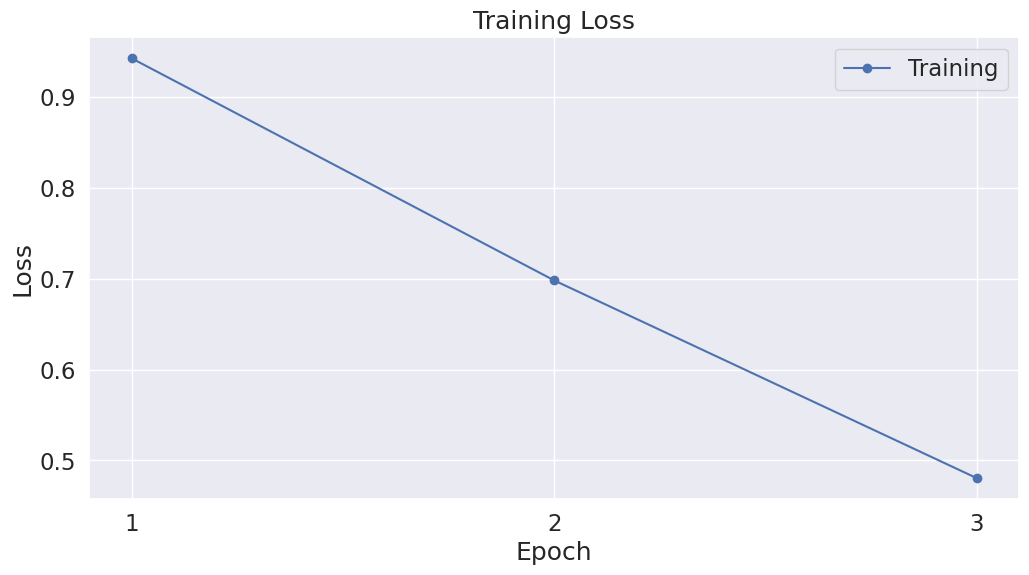

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_stats = pd.read_parquet(f"{output_dir}/training_stats.parquet")

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")

plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

13. Load and test the model.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = torch.device("cuda"  if torch.cuda.is_available() else  "cpu")

tokenizer = AutoTokenizer.from_pretrained(f"nicholasKluge/Aira-2-774M")
aira = AutoModelForCausalLM.from_pretrained(f"nicholasKluge/Aira-2-774M")

aira.eval()
aira.to(device)

question =  input("Enter your question: ")

inputs = tokenizer(tokenizer.bos_token + question + tokenizer.sep_token, return_tensors="pt").to(device)

responses = aira.generate(**inputs,
    bos_token_id=tokenizer.bos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
    top_k=20,
    max_length=530,
    top_p=0.20,
    temperature=0.2,
    num_return_sequences=2)

print(f"Question: 👤 {question}\n")

for i, response in  enumerate(responses):
    print(f'Response {i+1}: 🤖 {tokenizer.decode(response, skip_special_tokens=True).replace(question, "")}')

Question: 👤 What is your name?

Response 1: 🤖 I am an AI assistant called Aira. How can I help you today?
Response 2: 🤖 I am an AI assistant called Aira. How can I help you today?


Done! 🤗